In [43]:
# !pip uninstall sklearn -y
# !pip install scikit-learn==0.22.2.post1
import os
import h5py
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)
np.set_printoptions(threshold=np.inf)
from sklearn import linear_model, svm, tree, model_selection, preprocessing, metrics, ensemble, neural_network, dummy, neighbors, pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
import scipy
import itertools
import os 
import statistics 


In [74]:
file_name = "iawe_13m_100S1X_9A10000000N_AB"
dir_path =os.path.abspath(os.getcwd())
try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/Colab Notebooks/MSC/datasets/"f"{file_name}"
except:
    print("reading from HDD")
    path = dir_path+"/data"

#check if file exists
try:
    file = h5py.File(f"{path}"".hdf5","r+")
    print("file exists, reading it...")
except:
    print("error reading the file!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
reading from cloud...
file exists, reading it...


In [16]:
def plot_confusion_matrix(cm,
                          target_names,
                          title="Confusion Matrix",
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "midnightblue")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "midnightblue")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

def classification_report_with_accuracy_score(y_true, y_pred):

    print(classification_report(y_true, y_pred, digits=3)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score
   

In [95]:
#appliance_set = set()
appliance_instances = {}
all_appliances = []
datasets = ["iawe"]
appliances_len = {}

for dataset in datasets:
      
    for appliance in file[dataset].keys():

        for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
            all_appliances.append(appliance)
            #appliance_set.add(appliance)
            
            samples = file[f"{dataset}""/"f"{appliance}""/"f"{building}""/sig"].shape[0]
            
            if appliance in appliances_len:
                appliances_len[appliance].append(samples)#appliances_len[appliance] = appliances_len[appliance]+samples
            else:
                appliances_len[appliance] = [samples]
          
#available_appliances = list(appliance_set)
available_appliances_arr, instances = np.unique(all_appliances,return_counts=True)
available_appliances = list(available_appliances_arr)
for i,appliance in enumerate(available_appliances):
    appliance_instances[appliance] = instances[i]
    
print("available",available_appliances)
print("lengts",appliances_len)
print("instances",appliance_instances)

# Remove appliances with low numbe of samples.

n_samples_treshold = 50;

grouped_appliances = {} 

HEKA = ["toaster", "kettle"]
FF = ["fridge","freezer","fridge/freezer"]

for appl in appliances_len:
  
  if appliances_len[appl][0] < n_samples_treshold:
    available_appliances.remove(appl)
    print("removed ",appl," due to low number of samples:  ",appliances_len[appl][0]) 

  if appl in HEKA and appl in available_appliances:
    grouped_appliances.setdefault("HEKA",[]).append(appl)
    available_appliances.remove(appl)

  if appl in FF and appl in available_appliances:
    grouped_appliances.setdefault("FF",[]).append(appl)
    available_appliances.remove(appl)

for a in available_appliances:
    grouped_appliances[a] = [a]

print(grouped_appliances)


available ['air conditioner', 'clothes iron', 'computer', 'fridge', 'motor', 'television', 'unknown', 'washing machine', 'wet appliance']
lengts {'air conditioner': [1134], 'clothes iron': [4], 'computer': [2903], 'fridge': [5274], 'motor': [106], 'television': [502], 'unknown': [1], 'washing machine': [23], 'wet appliance': [339]}
instances {'air conditioner': 1, 'clothes iron': 1, 'computer': 1, 'fridge': 1, 'motor': 1, 'television': 1, 'unknown': 1, 'washing machine': 1, 'wet appliance': 1}
removed  clothes iron  due to low number of samples:   4
removed  unknown  due to low number of samples:   1
removed  washing machine  due to low number of samples:   23
{'FF': ['fridge'], 'air conditioner': ['air conditioner'], 'computer': ['computer'], 'motor': ['motor'], 'television': ['television'], 'wet appliance': ['wet appliance']}


In [96]:
##load datasset for normal use
N_wanted = 120000
fshrt = file[f"{dataset}""/"f"{appliance}""/"f"{building}""/sig"].shape
data = np.empty([0,fshrt[1],fshrt[2]])

labels = np.empty(0)
labels_state = np.empty(0)
labels_time = np.empty([0,fshrt[1],fshrt[2]])
labels_ds = np.empty(0)

appliances = []
num_of_buildings_arr = []


#appliances = available_appliances 
appliances = list(grouped_appliances)

counter1 = 0
last_appliance1 = 0
counter2 = 0
last_appliance2 = 0

for dataset in datasets:
  # Check last len so that number of appliances is balanced
  
    for appliance in file[dataset].keys():
    
        #train on all available appliances from refit change for test
        if appliance in sum(list(grouped_appliances.values()),[]):
            
            index = None
            for i,e in enumerate(list(grouped_appliances.values())):
                if appliance in e:
                #print("ok",i)
                    index = i
    
            grouped_appliance = list(grouped_appliances.keys())[index]
                
            
            #num_of_buildings = 0
            for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
              #num_of_buidlings += 1

                  
                        N  = 1000
                        
                        #current number of samples
                        samples = fshrt[0]
                        N = N_wanted/statistics.mean(appliances_len[appliance])
                        print("***",N)
                        N = int(N*N*samples)
                        print("***",samples)
                        if appliance in HEKA:
                            
                            if appliance != last_appliance1:
                                counter1 += 1
                            last_appliance1 = appliance
                            N = int(N/len(HEKA))*counter1
                        
                        if appliance in FF:
                            
                            if appliance != last_appliance2:
                                counter2 += 1
                            last_appliance2 = appliance
                            N = int(N/len(FF))*counter2
                            
                        appl_sample_len = len(np.where(labels == list(grouped_appliances.keys()).index(grouped_appliance))[0])
                        #N = N - appl_sample_len
#                         if appl_sample_len  > N_wanted:#1900:
#                             print("skiping.. max len exeeded",appliance,building,appl_sample_len)
#                             continue
                    
                        #images = np.array()

                        images = file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['sig'][0:N,...]
                        #images = images[N+1:-1,...]

                        data = np.append(data,images,axis=0)

                        

                        array_of_labels = np.ones(images.shape[0])*list(grouped_appliances.keys()).index(grouped_appliance)
                        labels = np.append(labels,array_of_labels)

                        array_of_labels_ds =  np.ones(images.shape[0])*datasets.index(dataset)
                        labels_ds = np.append(labels_ds,array_of_labels_ds)
                        
                        try:
                          labels_state = np.append(labels_state, file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['state'][0:N,...]) 
                        except KeyError:
                          lables_state = np.ones([images.shape[0]])

                        labels_time = np.append( labels_time, file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['ts'][0:N,...] , axis=0 )

                        #array_of_labels_buildings = np.ones(images.shape[0])*datasets.index(dataset)
                        #labels_buildings = 

                        print("dataset",dataset,"app",appliance,"bui",building,"curr data",images.shape[0],"shape",data.shape,"labels",labels.shape,"dsshape",labels_ds.shape," labels state", labels_state.shape," labels time",labels_time.shape)
#                 else:
#                     print("skipped appl: ",appliance," group ",list(grouped_appliances.keys()).index(appliance)," and dataset:",dataset," due to len: ",(len(np.where(labels == appliances.index(appliance))[0]) - last_length))
        

print("unique labels",np.unique(labels))
print("unique timestampts",np.unique(labels_time).shape[0])
print("unique state labels",np.unique(labels_state))

print("dataset: ",np.unique(labels_ds))

print(data.shape)
print(labels.shape)
print(labels_ds.shape)

print("appliances", appliances)
#print(labels)
#print([key for key in file["data"].keys()])

*** 105.82010582010582
*** 339
dataset iawe app air conditioner bui 1 curr data 1134 shape (1134, 1, 130) labels (1134,) dsshape (1134,)  labels state (0,)  labels time (1134, 1, 130)
*** 41.33654839820875
*** 339
dataset iawe app computer bui 1 curr data 2903 shape (4037, 1, 130) labels (4037,) dsshape (4037,)  labels state (0,)  labels time (4037, 1, 130)
*** 22.753128555176335
*** 339
dataset iawe app fridge bui 1 curr data 5274 shape (9311, 1, 130) labels (9311,) dsshape (9311,)  labels state (0,)  labels time (9311, 1, 130)
*** 1132.0754716981132
*** 339
dataset iawe app motor bui 1 curr data 106 shape (9417, 1, 130) labels (9417,) dsshape (9417,)  labels state (0,)  labels time (9417, 1, 130)
*** 239.0438247011952
*** 339
dataset iawe app television bui 1 curr data 502 shape (9919, 1, 130) labels (9919,) dsshape (9919,)  labels state (0,)  labels time (9919, 1, 130)
*** 353.98230088495575
*** 339
dataset iawe app wet appliance bui 1 curr data 339 shape (10258, 1, 130) labels (102

In [101]:
sum_all = 0
for i in range(len(appliances)):
  print(appliances[i],len(np.where(labels == i)[0]) )
  sum_all += len(np.where(labels == i)[0])
print("number of samples:",sum_all)

FF 5274
air conditioner 1134
computer 2903
motor 106
television 502
wet appliance 339
number of samples: 10258


In [80]:
images.shape[0]

1134

In [69]:
# Fix compatibility
raw_data = data[:,0]
label = labels 

In [70]:
raw_data.shape

(17480, 130)

In [97]:
#creation of synthetic features

#checks how many times the coefficient of the line connecting neighbouring points changes sign within a sample
def n_turns(array_input):
  count=0
  sign0=np.sign(array_input[1]-array_input[0])
  for i in range(len(array_input)-1):
    tmpsign=np.sign(array_input[i+1]-array_input[i])
    if tmpsign != sign0:
      count+=1
      sign0=tmpsign
  return count


#sums all differences between neighbouring points in a sample
def abs_derivative(array_input):
  sum=0
  for i in range(len(array_input)-1):
    sum+=np.abs(array_input[i+1]-array_input[i])
  return sum

data_avg=[np.mean(i) for i in raw_data]
data_avg2=[np.mean(i)**2 for i in raw_data]
data_skew=[scipy.stats.skew(i) for i in raw_data]
data_skew2=[scipy.stats.skew(i)**2 for i in raw_data]
data_kurt=[scipy.stats.kurtosis(i) for i in raw_data]
data_std=[np.std(i) for i in raw_data]
data_std2=[np.std(i)**2 for i in raw_data]
data_min=[min(i) for i in raw_data]
data_max=[max(i) for i in raw_data]
data_p2p=[max(i)-min(i) for i in raw_data]
data_sum=[sum(i) for i in raw_data]
data_var=[np.var(i) for i in raw_data]
data_med=[np.median(i) for i in raw_data]
data_nturns=[n_turns(i) for i in raw_data]
data_d_abs=[abs_derivative(i) for i in raw_data]

y=label

In [98]:
appliances

['FF', 'air conditioner', 'computer', 'motor', 'television', 'wet appliance']

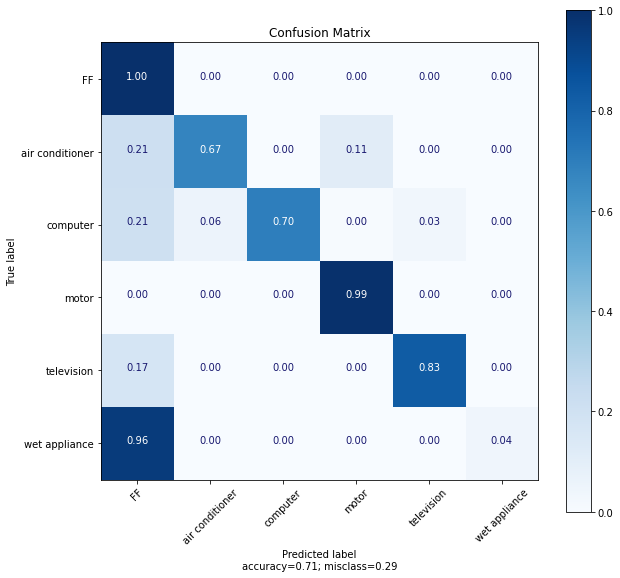

In [100]:
#best model, results shown in a confusion matrix, model pickled
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

# clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
#     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
#     max_iter=-1, probability=False, random_state=None, shrinking=True,
#     tol=0.001, verbose=False)

clf = neural_network.MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate="adaptive",
              learning_rate_init=0.45, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([("scaler", scaler),('clf', clf)])

X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

#y_pred = model_selection.cross_val_predict(clf, X, y, cv=5)
clf.fit(X_train, y_train)
import pickle
pickle.dump(clf, open("nilm_classifier_pickle", "wb"))
y_pred=clf.predict(X_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred, normalize="true")
plot_confusion_matrix(conf_mat, appliances, normalize="true",cmap="Blues")


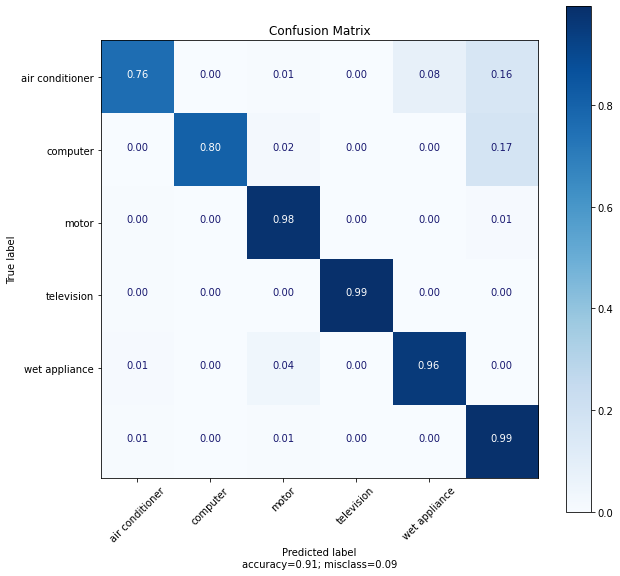

In [92]:
#similar as above, data not scaled
pipe = pipeline.Pipeline([
      
      ('clf', clf)
])
#y_pred = model_selection.cross_val_predict(clf, X, y, cv=5)
pipe.fit(X_train, y_train)
y_pred=pipe.predict(X_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred, normalize="true")
plot_confusion_matrix(conf_mat, appliances, normalize="true",cmap="Blues")

In [ ]:
#a more robust validation, takes longer to run so only a 5 fold split was used in later code
results=[]
for i in range(100):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

  X_train=preprocessing.StandardScaler().fit_transform(X_train)
  X_test=preprocessing.StandardScaler().fit_transform(X_test)
  clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

  clf.fit(X_train, y_train)
  accuracy = model_selection.cross_val_score(clf, X, y, cv=20)
  # metrics.plot_confusion_matrix(clf, X_test, y_test, normalize="true",cmap="Blues")
  results.append(accuracy)
  print(i)
print(np.mean(results))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.7181481481481481


In [ ]:
#best classifiers from every algorithm

clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

clf = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

clf = neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

clf = linear_model.LogisticRegression(C=20000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

clf = neural_network.MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.45, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Effects of feature selection

In [ ]:
X=np.vstack([raw_data])

clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.469     0.383     0.422        60
         1.0      0.722     0.867     0.788        60
         2.0      0.300     0.700     0.420        60
         3.0      0.263     0.167     0.204        60
         4.0      0.464     0.217     0.295        60
         5.0      0.543     0.417     0.472        60
         6.0      0.415     0.733     0.530        60
         7.0      0.000     0.000     0.000        60
         8.0      0.855     0.783     0.817        60

    accuracy                          0.474       540
   macro avg      0.448     0.474     0.439       540
weighted avg      0.448     0.474     0.439       540

              precision    recall  f1-score   support

         0.0      0.270     0.167     0.206        60
         1.0      0.642     0.717     0.677        60
         2.0      0.318     0.933     0.475        60
         3.0      0.244     0.167     0.198        60
         4.0      0.769 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std, data_avg2, data_skew2, data_std2, data_min, data_max, data_sum, data_med])
X=np.transpose(X)

clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score)))

              precision    recall  f1-score   support

         0.0      0.885     0.767     0.821        60
         1.0      0.817     0.967     0.885        60
         2.0      0.943     0.833     0.885        60
         3.0      0.930     0.667     0.777        60
         4.0      0.722     0.650     0.684        60
         5.0      0.982     0.933     0.957        60
         6.0      0.716     0.967     0.823        60
         7.0      0.696     0.800     0.744        60
         8.0      0.967     0.967     0.967        60

    accuracy                          0.839       540
   macro avg      0.851     0.839     0.838       540
weighted avg      0.851     0.839     0.838       540

              precision    recall  f1-score   support

         0.0      0.892     0.550     0.680        60
         1.0      0.915     0.900     0.908        60
         2.0      0.951     0.967     0.959        60
         3.0      0.957     0.750     0.841        60
         4.0      0.653 

In [ ]:
X=np.vstack([data_avg, data_std])
X=np.transpose(X)

clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.708     0.567     0.630        60
         1.0      0.763     0.967     0.853        60
         2.0      0.376     0.833     0.518        60
         3.0      0.953     0.683     0.796        60
         4.0      0.897     0.433     0.584        60
         5.0      0.702     0.550     0.617        60
         6.0      0.724     0.917     0.809        60
         7.0      0.958     0.383     0.548        60
         8.0      0.906     0.967     0.935        60

    accuracy                          0.700       540
   macro avg      0.776     0.700     0.699       540
weighted avg      0.776     0.700     0.699       540

              precision    recall  f1-score   support

         0.0      0.574     0.450     0.505        60
         1.0      0.766     0.817     0.790        60
         2.0      0.381     0.933     0.541        60
         3.0      0.872     0.683     0.766        60
         4.0      0.844 

In [ ]:
X=np.vstack([data_min, data_max, data_med])
X=np.transpose(X)

clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.712     0.783     0.746        60
         1.0      0.903     0.933     0.918        60
         2.0      0.406     0.933     0.566        60
         3.0      0.857     0.600     0.706        60
         4.0      1.000     0.467     0.636        60
         5.0      1.000     0.633     0.776        60
         6.0      0.718     0.933     0.812        60
         7.0      0.958     0.383     0.548        60
         8.0      0.875     0.933     0.903        60

    accuracy                          0.733       540
   macro avg      0.826     0.733     0.734       540
weighted avg      0.826     0.733     0.734       540

              precision    recall  f1-score   support

         0.0      0.650     0.433     0.520        60
         1.0      0.833     0.833     0.833        60
         2.0      0.387     0.917     0.545        60
         3.0      0.950     0.633     0.760        60
         4.0      1.000 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score)))

              precision    recall  f1-score   support

         0.0      0.870     0.783     0.825        60
         1.0      0.851     0.950     0.898        60
         2.0      0.944     0.850     0.895        60
         3.0      0.976     0.667     0.792        60
         4.0      0.702     0.667     0.684        60
         5.0      0.983     0.967     0.975        60
         6.0      0.734     0.967     0.835        60
         7.0      0.696     0.800     0.744        60
         8.0      0.967     0.967     0.967        60

    accuracy                          0.846       540
   macro avg      0.858     0.846     0.846       540
weighted avg      0.858     0.846     0.846       540

              precision    recall  f1-score   support

         0.0      0.914     0.533     0.674        60
         1.0      0.883     0.883     0.883        60
         2.0      0.966     0.950     0.958        60
         3.0      0.978     0.750     0.849        60
         4.0      0.640 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var,
             data_nturns, data_d_abs, data_std, data_avg2, data_skew2, data_std2, data_min, data_max, data_sum, data_med])
X=np.transpose(X)

clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score)))

              precision    recall  f1-score   support

         0.0      0.885     0.767     0.821        60
         1.0      0.817     0.967     0.885        60
         2.0      0.943     0.833     0.885        60
         3.0      0.930     0.667     0.777        60
         4.0      0.722     0.650     0.684        60
         5.0      0.982     0.933     0.957        60
         6.0      0.716     0.967     0.823        60
         7.0      0.696     0.800     0.744        60
         8.0      0.967     0.967     0.967        60

    accuracy                          0.839       540
   macro avg      0.851     0.839     0.838       540
weighted avg      0.851     0.839     0.838       540

              precision    recall  f1-score   support

         0.0      0.892     0.550     0.680        60
         1.0      0.915     0.900     0.908        60
         2.0      0.951     0.967     0.959        60
         3.0      0.957     0.750     0.841        60
         4.0      0.653 

Effects of scaling

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.870     0.783     0.825        60
         1.0      0.851     0.950     0.898        60
         2.0      0.944     0.850     0.895        60
         3.0      0.976     0.667     0.792        60
         4.0      0.702     0.667     0.684        60
         5.0      0.983     0.967     0.975        60
         6.0      0.734     0.967     0.835        60
         7.0      0.696     0.800     0.744        60
         8.0      0.967     0.967     0.967        60

    accuracy                          0.846       540
   macro avg      0.858     0.846     0.846       540
weighted avg      0.858     0.846     0.846       540

              precision    recall  f1-score   support

         0.0      0.914     0.533     0.674        60
         1.0      0.883     0.883     0.883        60
         2.0      0.966     0.950     0.958        60
         3.0      0.978     0.750     0.849        60
         4.0      0.640 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.852     0.383     0.529        60
         1.0      0.859     0.917     0.887        60
         2.0      0.708     0.850     0.773        60
         3.0      0.884     0.633     0.738        60
         4.0      0.479     0.933     0.633        60
         5.0      0.963     0.867     0.912        60
         6.0      0.689     0.850     0.761        60
         7.0      0.750     0.350     0.477        60
         8.0      0.951     0.967     0.959        60

    accuracy                          0.750       540
   macro avg      0.793     0.750     0.741       540
weighted avg      0.793     0.750     0.741       540

              precision    recall  f1-score   support

         0.0      0.947     0.300     0.456        60
         1.0      0.833     0.583     0.686        60
         2.0      0.729     0.850     0.785        60
         3.0      0.950     0.633     0.760        60
         4.0      0.452 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.579     0.733     0.647        60
         1.0      0.846     0.917     0.880        60
         2.0      0.962     0.850     0.903        60
         3.0      0.820     0.833     0.826        60
         4.0      0.696     0.650     0.672        60
         5.0      0.926     0.833     0.877        60
         6.0      0.807     0.767     0.786        60
         7.0      0.712     0.617     0.661        60
         8.0      0.879     0.967     0.921        60

    accuracy                          0.796       540
   macro avg      0.803     0.796     0.797       540
weighted avg      0.803     0.796     0.797       540

              precision    recall  f1-score   support

         0.0      0.679     0.633     0.655        60
         1.0      0.806     0.833     0.820        60
         2.0      0.921     0.967     0.943        60
         3.0      0.750     0.900     0.818        60
         4.0      0.638 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.629     0.733     0.677        60
         1.0      0.770     0.950     0.851        60
         2.0      0.981     0.867     0.920        60
         3.0      0.772     0.733     0.752        60
         4.0      0.717     0.633     0.673        60
         5.0      0.912     0.867     0.889        60
         6.0      0.600     0.600     0.600        60
         7.0      0.600     0.550     0.574        60
         8.0      0.934     0.950     0.942        60

    accuracy                          0.765       540
   macro avg      0.768     0.765     0.764       540
weighted avg      0.768     0.765     0.764       540

              precision    recall  f1-score   support

         0.0      0.621     0.683     0.651        60
         1.0      0.804     0.750     0.776        60
         2.0      0.887     0.917     0.902        60
         3.0      0.681     0.817     0.742        60
         4.0      0.613 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.597     0.767     0.672        60
         1.0      0.879     0.967     0.921        60
         2.0      0.966     0.950     0.958        60
         3.0      0.831     0.817     0.824        60
         4.0      0.814     0.583     0.680        60
         5.0      0.947     0.900     0.923        60
         6.0      0.845     0.817     0.831        60
         7.0      0.650     0.650     0.650        60
         8.0      0.951     0.967     0.959        60

    accuracy                          0.824       540
   macro avg      0.831     0.824     0.824       540
weighted avg      0.831     0.824     0.824       540

              precision    recall  f1-score   support

         0.0      0.818     0.600     0.692        60
         1.0      0.797     0.917     0.853        60
         2.0      1.000     0.933     0.966        60
         3.0      0.833     0.833     0.833        60
         4.0      0.692 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.631     0.683     0.656        60
         1.0      0.906     0.967     0.935        60
         2.0      0.983     0.967     0.975        60
         3.0      0.820     0.833     0.826        60
         4.0      0.667     0.567     0.613        60
         5.0      0.903     0.933     0.918        60
         6.0      0.842     0.800     0.821        60
         7.0      0.639     0.650     0.645        60
         8.0      0.967     0.967     0.967        60

    accuracy                          0.819       540
   macro avg      0.818     0.819     0.817       540
weighted avg      0.818     0.819     0.817       540

              precision    recall  f1-score   support

         0.0      0.731     0.633     0.679        60
         1.0      0.806     0.900     0.850        60
         2.0      1.000     0.933     0.966        60
         3.0      0.833     0.833     0.833        60
         4.0      0.639 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = linear_model.LogisticRegression(C=20000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.848     0.650     0.736        60
         1.0      0.795     0.967     0.872        60
         2.0      0.936     0.733     0.822        60
         3.0      0.891     0.683     0.774        60
         4.0      0.611     0.733     0.667        60
         5.0      0.931     0.900     0.915        60
         6.0      0.750     0.900     0.818        60
         7.0      0.694     0.717     0.705        60
         8.0      0.906     0.967     0.935        60

    accuracy                          0.806       540
   macro avg      0.818     0.806     0.805       540
weighted avg      0.818     0.806     0.805       540

              precision    recall  f1-score   support

         0.0      0.929     0.433     0.591        60
         1.0      0.727     0.800     0.762        60
         2.0      0.913     0.700     0.792        60
         3.0      0.952     0.667     0.784        60
         4.0      0.600 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = linear_model.LogisticRegression(C=20000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.778     0.583     0.667        60
         1.0      0.600     0.950     0.735        60
         2.0      0.857     0.400     0.545        60
         3.0      0.800     0.667     0.727        60
         4.0      0.530     0.883     0.662        60
         5.0      0.898     0.883     0.891        60
         6.0      0.757     0.883     0.815        60
         7.0      1.000     0.383     0.554        60
         8.0      0.843     0.983     0.908        60

    accuracy                          0.735       540
   macro avg      0.785     0.735     0.723       540
weighted avg      0.785     0.735     0.723       540

              precision    recall  f1-score   support

         0.0      0.960     0.400     0.565        60
         1.0      0.610     0.783     0.686        60
         2.0      0.298     0.567     0.391        60
         3.0      0.827     0.717     0.768        60
         4.0      0.853 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = neural_network.MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.45, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.836     0.767     0.800        60
         1.0      0.877     0.950     0.912        60
         2.0      0.981     0.867     0.920        60
         3.0      0.953     0.683     0.796        60
         4.0      0.691     0.783     0.734        60
         5.0      0.966     0.950     0.958        60
         6.0      0.760     0.950     0.844        60
         7.0      0.710     0.733     0.721        60
         8.0      0.967     0.967     0.967        60

    accuracy                          0.850       540
   macro avg      0.860     0.850     0.850       540
weighted avg      0.860     0.850     0.850       540

              precision    recall  f1-score   support

         0.0      0.882     0.500     0.638        60
         1.0      0.871     0.900     0.885        60
         2.0      0.965     0.917     0.940        60
         3.0      1.000     0.717     0.835        60
         4.0      0.687 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = neural_network.MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.45, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0      0.111     1.000     0.200        60
         1.0      0.000     0.000     0.000        60
         2.0      0.000     0.000     0.000        60
         3.0      0.000     0.000     0.000        60
         4.0      0.000     0.000     0.000        60
         5.0      0.000     0.000     0.000        60
         6.0      0.000     0.000     0.000        60
         7.0      0.000     0.000     0.000        60
         8.0      0.000     0.000     0.000        60

    accuracy                          0.111       540
   macro avg      0.012     0.111     0.022       540
weighted avg      0.012     0.111     0.022       540



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000        60
         1.0      0.000     0.000     0.000        60
         2.0      0.111     1.000     0.200        60
         3.0      0.000     0.000     0.000        60
         4.0      0.000     0.000     0.000        60
         5.0      0.000     0.000     0.000        60
         6.0      0.000     0.000     0.000        60
         7.0      0.000     0.000     0.000        60
         8.0      0.000     0.000     0.000        60

    accuracy                          0.111       540
   macro avg      0.012     0.111     0.022       540
weighted avg      0.012     0.111     0.022       540



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000        60
         1.0      0.000     0.000     0.000        60
         2.0      0.000     0.000     0.000        60
         3.0      0.000     0.000     0.000        60
         4.0      0.000     0.000     0.000        60
         5.0      0.000     0.000     0.000        60
         6.0      0.000     0.000     0.000        60
         7.0      0.111     1.000     0.200        60
         8.0      0.000     0.000     0.000        60

    accuracy                          0.111       540
   macro avg      0.012     0.111     0.022       540
weighted avg      0.012     0.111     0.022       540



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000        60
         1.0      0.000     0.000     0.000        60
         2.0      0.000     0.000     0.000        60
         3.0      0.111     1.000     0.200        60
         4.0      0.000     0.000     0.000        60
         5.0      0.000     0.000     0.000        60
         6.0      0.000     0.000     0.000        60
         7.0      0.000     0.000     0.000        60
         8.0      0.000     0.000     0.000        60

    accuracy                          0.111       540
   macro avg      0.012     0.111     0.022       540
weighted avg      0.012     0.111     0.022       540

              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000        60
         1.0      0.111     1.000     0.200        60
         2.0      0.000     0.000     0.000        60
         3.0      0.000     0.000     0.000        60
         4.0      0.000 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Algorithm optimisation

In [ ]:
#example code used to optimise algorithms

# from sklearn import svm, datasets, preprocessing
# from sklearn.model_selection import GridSearchCV
# import numpy as np

# X=np.vstack([data_avg, data_skew, data_std, data_p2p, data_nturns, data_d_abs])
# X=preprocessing.StandardScaler().fit_transform(X)
# X=np.transpose(X)

# parameters = {"n_estimators":range(1, 1000, 50), "min_samples_leaf":[1,2,3,4,5]}
# clf = ensemble.RandomForestClassifier()

# cv = GridSearchCV(clf,
#              param_grid=parameters)
# cv.fit(X, y)
# print(cv.best_estimator_)

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = svm.SVC()

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.421     0.133     0.203        60
         1.0      0.914     0.883     0.898        60
         2.0      0.980     0.800     0.881        60
         3.0      1.000     0.617     0.763        60
         4.0      0.523     0.950     0.675        60
         5.0      0.682     0.750     0.714        60
         6.0      0.691     0.933     0.794        60
         7.0      0.920     0.383     0.541        60
         8.0      0.615     0.983     0.756        60

    accuracy                          0.715       540
   macro avg      0.749     0.715     0.692       540
weighted avg      0.749     0.715     0.692       540

              precision    recall  f1-score   support

         0.0      0.500     0.150     0.231        60
         1.0      0.933     0.467     0.622        60
         2.0      0.942     0.817     0.875        60
         3.0      0.950     0.633     0.760        60
         4.0      0.466 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = svm.SVC(C=38000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.870     0.783     0.825        60
         1.0      0.851     0.950     0.898        60
         2.0      0.944     0.850     0.895        60
         3.0      0.976     0.667     0.792        60
         4.0      0.702     0.667     0.684        60
         5.0      0.983     0.967     0.975        60
         6.0      0.734     0.967     0.835        60
         7.0      0.696     0.800     0.744        60
         8.0      0.967     0.967     0.967        60

    accuracy                          0.846       540
   macro avg      0.858     0.846     0.846       540
weighted avg      0.858     0.846     0.846       540

              precision    recall  f1-score   support

         0.0      0.914     0.533     0.674        60
         1.0      0.883     0.883     0.883        60
         2.0      0.966     0.950     0.958        60
         3.0      0.978     0.750     0.849        60
         4.0      0.640 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = neighbors.KNeighborsClassifier()

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.571     0.733     0.642        60
         1.0      0.824     0.933     0.875        60
         2.0      0.962     0.850     0.903        60
         3.0      0.817     0.817     0.817        60
         4.0      0.735     0.600     0.661        60
         5.0      0.927     0.850     0.887        60
         6.0      0.825     0.783     0.803        60
         7.0      0.673     0.617     0.643        60
         8.0      0.879     0.967     0.921        60

    accuracy                          0.794       540
   macro avg      0.801     0.794     0.795       540
weighted avg      0.801     0.794     0.795       540

              precision    recall  f1-score   support

         0.0      0.649     0.617     0.632        60
         1.0      0.762     0.800     0.780        60
         2.0      0.921     0.967     0.943        60
         3.0      0.746     0.883     0.809        60
         4.0      0.710 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.579     0.733     0.647        60
         1.0      0.846     0.917     0.880        60
         2.0      0.962     0.850     0.903        60
         3.0      0.820     0.833     0.826        60
         4.0      0.696     0.650     0.672        60
         5.0      0.926     0.833     0.877        60
         6.0      0.807     0.767     0.786        60
         7.0      0.712     0.617     0.661        60
         8.0      0.879     0.967     0.921        60

    accuracy                          0.796       540
   macro avg      0.803     0.796     0.797       540
weighted avg      0.803     0.796     0.797       540

              precision    recall  f1-score   support

         0.0      0.679     0.633     0.655        60
         1.0      0.806     0.833     0.820        60
         2.0      0.921     0.967     0.943        60
         3.0      0.750     0.900     0.818        60
         4.0      0.638 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = neural_network.MLPClassifier()

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0      0.720     0.600     0.655        60
         1.0      0.917     0.917     0.917        60
         2.0      0.963     0.867     0.912        60
         3.0      0.889     0.667     0.762        60
         4.0      0.634     0.750     0.687        60
         5.0      0.906     0.800     0.850        60
         6.0      0.747     0.933     0.830        60
         7.0      0.683     0.683     0.683        60
         8.0      0.792     0.950     0.864        60

    accuracy                          0.796       540
   macro avg      0.806     0.796     0.795       540
weighted avg      0.806     0.796     0.795       540



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0      0.789     0.500     0.612        60
         1.0      0.927     0.850     0.887        60
         2.0      0.933     0.933     0.933        60
         3.0      0.957     0.733     0.830        60
         4.0      0.597     0.767     0.672        60
         5.0      0.862     0.833     0.847        60
         6.0      0.692     0.900     0.783        60
         7.0      0.619     0.650     0.634        60
         8.0      0.923     1.000     0.960        60

    accuracy                          0.796       540
   macro avg      0.811     0.796     0.795       540
weighted avg      0.811     0.796     0.795       540



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0      0.620     0.517     0.564        60
         1.0      0.920     0.767     0.836        60
         2.0      0.917     0.733     0.815        60
         3.0      0.946     0.583     0.722        60
         4.0      0.769     0.500     0.606        60
         5.0      0.786     0.733     0.759        60
         6.0      0.639     0.883     0.741        60
         7.0      0.524     0.900     0.663        60
         8.0      0.784     0.967     0.866        60

    accuracy                          0.731       540
   macro avg      0.767     0.731     0.730       540
weighted avg      0.767     0.731     0.730       540



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0      0.804     0.683     0.739        60
         1.0      0.814     0.583     0.680        60
         2.0      0.966     0.933     0.949        60
         3.0      0.923     0.800     0.857        60
         4.0      0.558     0.717     0.628        60
         5.0      0.818     0.750     0.783        60
         6.0      0.743     0.917     0.821        60
         7.0      0.667     0.667     0.667        60
         8.0      0.857     1.000     0.923        60

    accuracy                          0.783       540
   macro avg      0.794     0.783     0.783       540
weighted avg      0.794     0.783     0.783       540

              precision    recall  f1-score   support

         0.0      0.933     0.700     0.800        60
         1.0      0.812     0.433     0.565        60
         2.0      0.889     0.933     0.911        60
         3.0      0.894     0.700     0.785        60
         4.0      0.675 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = neural_network.MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.45, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.821     0.767     0.793        60
         1.0      0.950     0.950     0.950        60
         2.0      0.981     0.883     0.930        60
         3.0      0.911     0.683     0.781        60
         4.0      0.614     0.850     0.713        60
         5.0      0.966     0.950     0.958        60
         6.0      0.760     0.950     0.844        60
         7.0      0.750     0.600     0.667        60
         8.0      0.967     0.967     0.967        60

    accuracy                          0.844       540
   macro avg      0.858     0.844     0.845       540
weighted avg      0.858     0.844     0.845       540

              precision    recall  f1-score   support

         0.0      0.853     0.483     0.617        60
         1.0      0.885     0.900     0.893        60
         2.0      0.948     0.917     0.932        60
         3.0      1.000     0.733     0.846        60
         4.0      0.630 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = neural_network.MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(500,500), learning_rate='adaptive',
              learning_rate_init=0.45, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score)))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0      0.786     0.733     0.759        60
         1.0      0.866     0.967     0.913        60
         2.0      0.981     0.883     0.930        60
         3.0      0.932     0.683     0.788        60
         4.0      0.701     0.783     0.740        60
         5.0      0.950     0.950     0.950        60
         6.0      0.763     0.967     0.853        60
         7.0      0.732     0.683     0.707        60
         8.0      0.967     0.967     0.967        60

    accuracy                          0.846       540
   macro avg      0.853     0.846     0.845       540
weighted avg      0.853     0.846     0.845       540



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0      0.886     0.517     0.653        60
         1.0      0.833     0.917     0.873        60
         2.0      0.950     0.950     0.950        60
         3.0      1.000     0.733     0.846        60
         4.0      0.745     0.683     0.713        60
         5.0      0.951     0.967     0.959        60
         6.0      0.691     0.933     0.794        60
         7.0      0.628     0.817     0.710        60
         8.0      0.967     0.967     0.967        60

    accuracy                          0.831       540
   macro avg      0.850     0.831     0.829       540
weighted avg      0.850     0.831     0.829       540



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0      0.729     0.583     0.648        60
         1.0      0.964     0.900     0.931        60
         2.0      0.926     0.833     0.877        60
         3.0      0.973     0.600     0.742        60
         4.0      0.557     0.900     0.688        60
         5.0      0.859     0.917     0.887        60
         6.0      0.655     0.917     0.764        60
         7.0      0.818     0.450     0.581        60
         8.0      0.836     0.933     0.882        60

    accuracy                          0.781       540
   macro avg      0.813     0.781     0.778       540
weighted avg      0.813     0.781     0.778       540



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         0.0      0.860     0.817     0.838        60
         1.0      0.975     0.650     0.780        60
         2.0      0.984     1.000     0.992        60
         3.0      0.980     0.817     0.891        60
         4.0      0.566     0.783     0.657        60
         5.0      0.982     0.917     0.948        60
         6.0      0.727     0.933     0.818        60
         7.0      0.750     0.700     0.724        60
         8.0      1.000     1.000     1.000        60

    accuracy                          0.846       540
   macro avg      0.869     0.846     0.850       540
weighted avg      0.869     0.846     0.850       540

              precision    recall  f1-score   support

         0.0      0.948     0.917     0.932        60
         1.0      0.912     0.517     0.660        60
         2.0      0.919     0.950     0.934        60
         3.0      0.909     0.667     0.769        60
         4.0      0.667 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = neural_network.MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(500,500,500), learning_rate='adaptive',
              learning_rate_init=1, max_fun=15000, max_iter=200,
              momentum=0.45, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000        60
         1.0      0.000     0.000     0.000        60
         2.0      0.000     0.000     0.000        60
         3.0      0.929     0.217     0.351        60
         4.0      0.000     0.000     0.000        60
         5.0      0.000     0.000     0.000        60
         6.0      0.114     1.000     0.205        60
         7.0      0.000     0.000     0.000        60
         8.0      0.000     0.000     0.000        60

    accuracy                          0.135       540
   macro avg      0.116     0.135     0.062       540
weighted avg      0.116     0.135     0.062       540



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000        60
         1.0      0.000     0.000     0.000        60
         2.0      0.165     0.983     0.283        60
         3.0      0.295     0.900     0.444        60
         4.0      0.000     0.000     0.000        60
         5.0      0.000     0.000     0.000        60
         6.0      0.000     0.000     0.000        60
         7.0      0.000     0.000     0.000        60
         8.0      0.000     0.000     0.000        60

    accuracy                          0.209       540
   macro avg      0.051     0.209     0.081       540
weighted avg      0.051     0.209     0.081       540



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0      0.112     1.000     0.202        60
         1.0      0.000     0.000     0.000        60
         2.0      0.000     0.000     0.000        60
         3.0      1.000     0.100     0.182        60
         4.0      0.000     0.000     0.000        60
         5.0      0.000     0.000     0.000        60
         6.0      0.000     0.000     0.000        60
         7.0      0.000     0.000     0.000        60
         8.0      0.000     0.000     0.000        60

    accuracy                          0.122       540
   macro avg      0.124     0.122     0.043       540
weighted avg      0.124     0.122     0.043       540



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0      0.111     1.000     0.200        60
         1.0      0.000     0.000     0.000        60
         2.0      0.000     0.000     0.000        60
         3.0      0.000     0.000     0.000        60
         4.0      0.000     0.000     0.000        60
         5.0      0.000     0.000     0.000        60
         6.0      0.000     0.000     0.000        60
         7.0      0.000     0.000     0.000        60
         8.0      0.000     0.000     0.000        60

    accuracy                          0.111       540
   macro avg      0.012     0.111     0.022       540
weighted avg      0.012     0.111     0.022       540

              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000        60
         1.0      0.112     1.000     0.201        60
         2.0      0.000     0.000     0.000        60
         3.0      1.000     0.050     0.095        60
         4.0      0.000 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = linear_model.LogisticRegression()

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

         0.0      0.688     0.183     0.289        60
         1.0      0.695     0.950     0.803        60
         2.0      0.959     0.783     0.862        60
         3.0      0.950     0.633     0.760        60
         4.0      0.522     0.983     0.682        60
         5.0      0.679     0.600     0.637        60
         6.0      0.757     0.933     0.836        60
         7.0      1.000     0.383     0.554        60
         8.0      0.656     0.983     0.787        60

    accuracy                          0.715       540
   macro avg      0.767     0.715     0.690       540
weighted avg      0.767     0.715     0.690       540

              precision    recall  f1-score   support

         0.0      0.700     0.117     0.200        60
         1.0      0.781     0.833     0.806        60
         2.0      0.893     0.833     0.862        60
         3.0      0.923     0.600     0.727        60
         4.0      0.483 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

         0.0      0.696     0.267     0.386        60
         1.0      0.833     0.750     0.789        60
         2.0      0.755     0.617     0.679        60
         3.0      0.944     0.567     0.708        60
         4.0      0.471     0.933     0.626        60
         5.0      0.691     0.633     0.661        60
         6.0      0.627     0.867     0.727        60
         7.0      0.962     0.417     0.581        60
         8.0      0.589     0.933     0.723        60

    accuracy                          0.665       540
   macro avg      0.730     0.665     0.653       540
weighted avg      0.730     0.665     0.653       540

              precision    recall  f1-score   support

         0.0      0.567     0.283     0.378        60
         1.0      0.614     0.450     0.519        60
         2.0      0.980     0.800     0.881        60
         3.0      0.977     0.717     0.827        60
         4.0      0.509 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = linear_model.LogisticRegression(C=20000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.848     0.650     0.736        60
         1.0      0.795     0.967     0.872        60
         2.0      0.936     0.733     0.822        60
         3.0      0.891     0.683     0.774        60
         4.0      0.611     0.733     0.667        60
         5.0      0.931     0.900     0.915        60
         6.0      0.750     0.900     0.818        60
         7.0      0.694     0.717     0.705        60
         8.0      0.906     0.967     0.935        60

    accuracy                          0.806       540
   macro avg      0.818     0.806     0.805       540
weighted avg      0.818     0.806     0.805       540

              precision    recall  f1-score   support

         0.0      0.929     0.433     0.591        60
         1.0      0.727     0.800     0.762        60
         2.0      0.913     0.700     0.792        60
         3.0      0.952     0.667     0.784        60
         4.0      0.600 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = ensemble.RandomForestClassifier()

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.629     0.733     0.677        60
         1.0      0.868     0.983     0.922        60
         2.0      0.983     0.967     0.975        60
         3.0      0.831     0.817     0.824        60
         4.0      0.700     0.583     0.636        60
         5.0      0.948     0.917     0.932        60
         6.0      0.839     0.783     0.810        60
         7.0      0.610     0.600     0.605        60
         8.0      0.951     0.967     0.959        60

    accuracy                          0.817       540
   macro avg      0.818     0.817     0.816       540
weighted avg      0.818     0.817     0.816       540

              precision    recall  f1-score   support

         0.0      0.818     0.600     0.692        60
         1.0      0.789     0.933     0.855        60
         2.0      1.000     0.950     0.974        60
         3.0      0.833     0.833     0.833        60
         4.0      0.647 

In [ ]:
X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

scaler=preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])
print(np.mean(model_selection.cross_val_score(pipe, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

              precision    recall  f1-score   support

         0.0      0.614     0.717     0.662        60
         1.0      0.881     0.983     0.929        60
         2.0      0.983     0.967     0.975        60
         3.0      0.831     0.817     0.824        60
         4.0      0.767     0.550     0.641        60
         5.0      0.902     0.917     0.909        60
         6.0      0.839     0.783     0.810        60
         7.0      0.625     0.667     0.645        60
         8.0      0.951     0.967     0.959        60

    accuracy                          0.819       540
   macro avg      0.821     0.819     0.817       540
weighted avg      0.821     0.819     0.817       540

              precision    recall  f1-score   support

         0.0      0.814     0.583     0.680        60
         1.0      0.786     0.917     0.846        60
         2.0      1.000     0.933     0.966        60
         3.0      0.836     0.850     0.843        60
         4.0      0.662 

Experiments with auto ML

In [ ]:
!pip uninstall scipy -y
!pip install auto-sklearn
!pip install scipy 

Found existing installation: scipy 1.4.1
Uninstalling scipy-1.4.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scipy-1.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scipy/*
Proceed (y/n)?   ERROR: Operation cancelled by user
     |████████████████████████████████| 6.3 MB 8.6 MB/s 
     |████████████████████████████████| 38.1 MB 149 kB/s 
     |████████████████████████████████| 22.3 MB 1.4 MB/s 
     |████████████████████████████████| 722 kB 41.3 MB/s 
     |████████████████████████████████| 4.2 MB 40.0 MB/s 
     |████████████████████████████████| 4.0 MB 36.2 MB/s 
     |████████████████████████████████| 208 kB 49.6 MB/s 
     |████████████████████████████████| 973 kB 28.9 MB/s 
     |████████████████████████████████| 132 kB 64.6 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.14.2-py3-none-any.whl size=6586738 sha256=ef8dca0c5be004d629e7201c90df62208f29b8cd563b3e36de41e8eac2c76b53
  Sto

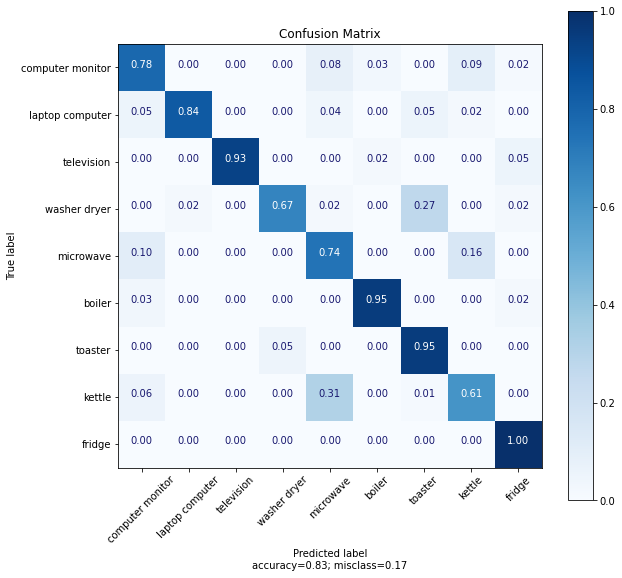

NameError: ignored

In [ ]:
#takes 2h to run
import autosklearn.classification
from sklearn import model_selection, metrics

X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

clf = autosklearn.classification.AutoSklearnClassifier()

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)



In [ ]:
clf.cv_results_
clf.sprint_statistics()
clf.show_models()


"[(0.320000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'polynomial', 'classifier:random_forest:bootstrap': 'False', 'classifier:random_forest:criterion': 'entropy', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.4332810836259261, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 2, 'classifier:random_forest:min_samples_split': 3, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessor:fe

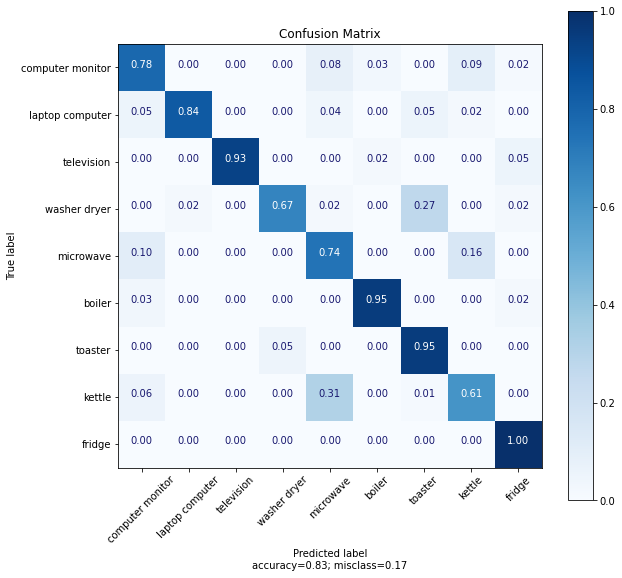

In [ ]:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(y_test, y_pred, normalize="true")
plot_confusion_matrix(conf_mat, manually_selected_appliances, normalize="true",cmap="Blues")

In [ ]:
#takes 10h to run in cross validation
import autosklearn.classification
from sklearn import model_selection, metrics

X=np.vstack([data_avg, data_skew, data_kurt, data_p2p, data_var, data_nturns, data_d_abs, data_std])
X=np.transpose(X)

clf = autosklearn.classification.AutoSklearnClassifier()

print(np.mean(model_selection.cross_val_score(clf, X, y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))))

Process ForkProcess-821:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/autosklearn/util/logging_.py", line 320, in start_log_server
    receiver.serve_until_stopped()
  File "/usr/local/lib/python3.7/dist-packages/autosklearn/util/logging_.py", line 352, in serve_until_stopped
    self.timeout)
KeyboardInterrupt
